In [1]:
# Import Required libraries
import pickle
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from prophet import Prophet
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as offline
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from ydata_profiling import ProfileReport
offline.init_notebook_mode(connected = True)

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Load Dataset
data = pd.read_csv("Super_Store_data.csv", encoding="latin1")

In [3]:
# Display the first top 5 rows of the dataset
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


#### Data Characterisitics

In [4]:
# Data Charactersisitcs of furniture sales data
print('Number of data samples: ', data.shape)
print('Number of features: ', len(data.columns))
print('Name of features: ',list(data.columns))
print('Data types of features: \n', data.dtypes)

Number of data samples:  (2121, 21)
Number of features:  21
Name of features:  ['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']
Data types of features: 
 Row ID             int64
Order ID          object
Order Date        object
Ship Date         object
Ship Mode         object
Customer ID       object
Customer Name     object
Segment           object
Country           object
City              object
State             object
Postal Code        int64
Region            object
Product ID        object
Category          object
Sub-Category      object
Product Name      object
Sales            float64
Quantity           int64
Discount         float64
Profit           float64
dtype: object


In [5]:
print("Information of dataset:", data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         2121 non-null   int64  
 1   Order ID       2121 non-null   object 
 2   Order Date     2121 non-null   object 
 3   Ship Date      2121 non-null   object 
 4   Ship Mode      2121 non-null   object 
 5   Customer ID    2121 non-null   object 
 6   Customer Name  2121 non-null   object 
 7   Segment        2121 non-null   object 
 8   Country        2121 non-null   object 
 9   City           2121 non-null   object 
 10  State          2121 non-null   object 
 11  Postal Code    2121 non-null   int64  
 12  Region         2121 non-null   object 
 13  Product ID     2121 non-null   object 
 14  Category       2121 non-null   object 
 15  Sub-Category   2121 non-null   object 
 16  Product Name   2121 non-null   object 
 17  Sales          2121 non-null   float64
 18  Quantity

In [6]:
print("Statistics Summary of the dataset: \n")
data.describe().T

Statistics Summary of the dataset: 



,count,mean,std,min,25%,50%,75%,max
Row ID,2121.0,5041.643564,2885.740258,1.0000,2568.000,5145.0000,7534.0000,9991.000
Postal Code,2121.0,55726.556341,32261.888225,1040.0000,22801.000,60505.0000,90032.0000,99301.000
Sales,2121.0,349.834887,503.179145,1.8920,47.040,182.2200,435.1680,4416.174
Quantity,2121.0,3.785007,2.251620,1.0000,2.000,3.0000,5.0000,14.000
Discount,2121.0,0.173923,0.181547,0.0000,0.000,0.2000,0.3000,0.700
Profit,2121.0,8.699327,136.049246,-1862.3124,-12.849,7.7748,33.7266,1013.127


#### Check Missing Value 

In [7]:
#check missing values
print(f'Checking Missing values for furniture store sales dataset: \n{data.isnull().sum()}')

Checking Missing values for furniture store sales dataset: 
Row ID           0
Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Customer Name    0
Segment          0
Country          0
City             0
State            0
Postal Code      0
Region           0
Product ID       0
Category         0
Sub-Category     0
Product Name     0
Sales            0
Quantity         0
Discount         0
Profit           0
dtype: int64


#### Observations:
We can see that there is no missing values found in the dataset. If there was any missing values in the dataset then based on the type of features, we would have to apply imputation method fo rfilling the missing values. Like for filling numerical features we would use median and for categorical features we can use mode (most frequesnt). Since there is no missing values, so we will not do any processing here.

#### Remove Duplicate Rows

In [8]:
# Check for duplicate rows
duplicate_rows = data.duplicated()

# Print the number of duplicate rows
print(f'Number of duplicate rows: {duplicate_rows.sum()}')

# Display the duplicate rows, if any
if duplicate_rows.sum() > 0:
    print('Duplicate rows:')
    print(data[duplicate_rows])
else:
    print('No duplicate rows found.')

Number of duplicate rows: 0
No duplicate rows found.


#### Observations:

There was no duplicates row was found in this dataset. If there was any duplicate rows then we would have to deal with it by dropping it since there is meaning of having same record multiple times as our model will get biased towards these record/data points while training.

In [9]:
# Checking for unique values
print('Unique values in each column: \n',data.nunique())

Unique values in each column: 
 Row ID           2121
Order ID         1764
Order Date        889
Ship Date         960
Ship Mode           4
Customer ID       707
Customer Name     707
Segment             3
Country             1
City              371
State              48
Postal Code       454
Region              4
Product ID        375
Category            1
Sub-Category        4
Product Name      380
Sales            1636
Quantity           14
Discount           11
Profit           1777
dtype: int64


In [10]:
# clean-column names for analysis
data.columns = [col.strip().lower().replace(" ", "_") for col in data.columns]

In [11]:
# Convert 'order_date' and 'ship_date' columns to datetime format
data['order_date'] = pd.to_datetime(data['order_date'])
data['ship_date'] = pd.to_datetime(data['ship_date'])
print("Checking the type of order_data & ship_date:\n")
data.info()

Checking the type of order_data & ship_date:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   row_id         2121 non-null   int64         
 1   order_id       2121 non-null   object        
 2   order_date     2121 non-null   datetime64[ns]
 3   ship_date      2121 non-null   datetime64[ns]
 4   ship_mode      2121 non-null   object        
 5   customer_id    2121 non-null   object        
 6   customer_name  2121 non-null   object        
 7   segment        2121 non-null   object        
 8   country        2121 non-null   object        
 9   city           2121 non-null   object        
 10  state          2121 non-null   object        
 11  postal_code    2121 non-null   int64         
 12  region         2121 non-null   object        
 13  product_id     2121 non-null   object        
 14  category       2121 non-nu

##### Observations: 
Since we found that order_date and ship_date columns, so converted it to proper date format for further processing.

#### Add temporal features

In [12]:
# Additional temporal features
data['year'] = data['order_date'].dt.year
data['month'] = data['order_date'].dt.month
data['day'] = data['order_date'].dt.day
data['Weekday'] = data['order_date'].dt.weekday
data['week'] = data['order_date'].dt.isocalendar().week
data['quarter'] = data['order_date'].dt.quarter

#### Observations:
From above we can see that temporal features has been added like year, month, week, quarter which will be later used for visulaization purposes and understanding the data.

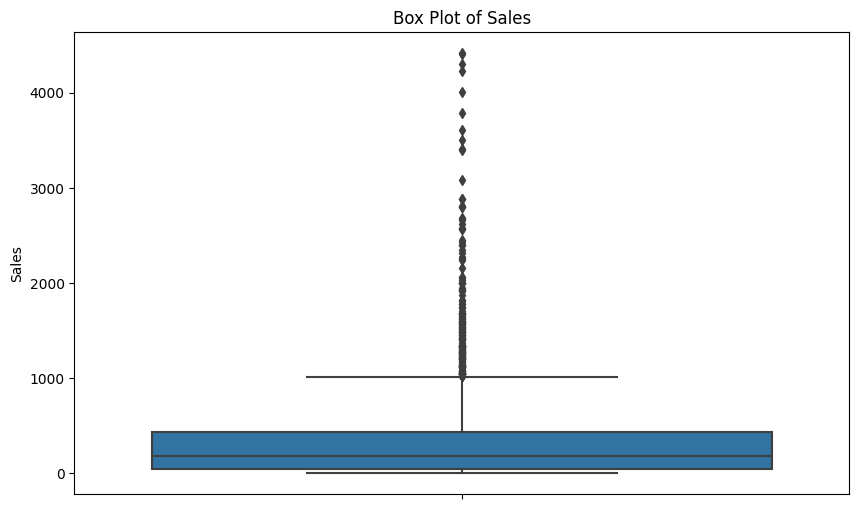

In [13]:
# Plot box-plots for sales
plt.figure(figsize=(10, 6))
sns.boxplot(y=data['sales'])
plt.title('Box Plot of Sales')
plt.ylabel('Sales')
plt.show()

#### Observations:

Above box-plot figure shows the presence of outliers in "sales" columns. So, we will be handling th eoutliers using IQR method in next steps.

In [14]:
# Applying the interquartile range system to selec and drop the outliers in column 'Sales'

Q1= data['sales'].quantile(0.25)
Q3= data['sales'].quantile(0.75)
IQR = Q3-Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

data_cleaned = data[(data['sales'] >= lower) & (data['sales'] <= upper)]

#### Observations:

We have used IQR method to remove outliers, for that first we have calculated Q1, Q3. and IQR (Inter-Quartile Range) that is the difference between Quarte 3 and 1 and then found the lower bound and upper bound and save the cleaned data

## Exploratory Data Analysis(EDA)

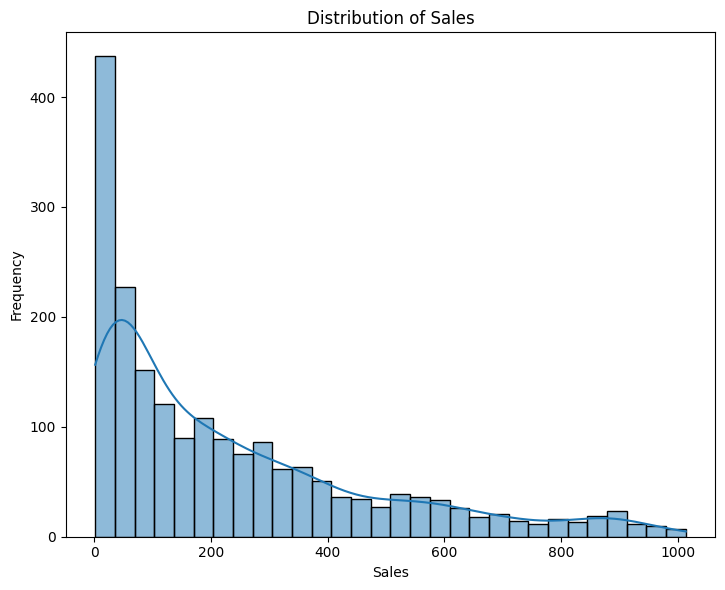

In [15]:
# Plot histplot to check distribution of sales
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data_cleaned['sales'], bins=30, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# # Box Plot
# plt.subplot(1, 2, 2)
# sns.boxplot(y=data_cleaned['sales'])
# plt.title('Box Plot of Sales')
# plt.ylabel('Sales')

plt.tight_layout()
plt.show()

#### Observations:
From above plot, we can see that 'sales' columns is left-skewed that means left tail is longer which indicates majority of data points are concentrated on the right, so there is a need to transform it using either log-transformation or box-cox transformation. ARIMA models doesn't perform well on skewed dataset, so we will transform using log transformation in next which is good for time series analysis.

In [16]:
# Applied log-transformation to the 'Sales' column to reduce the skewness
data_cleaned['log_sales'] = np.log1p(data_cleaned['sales'])


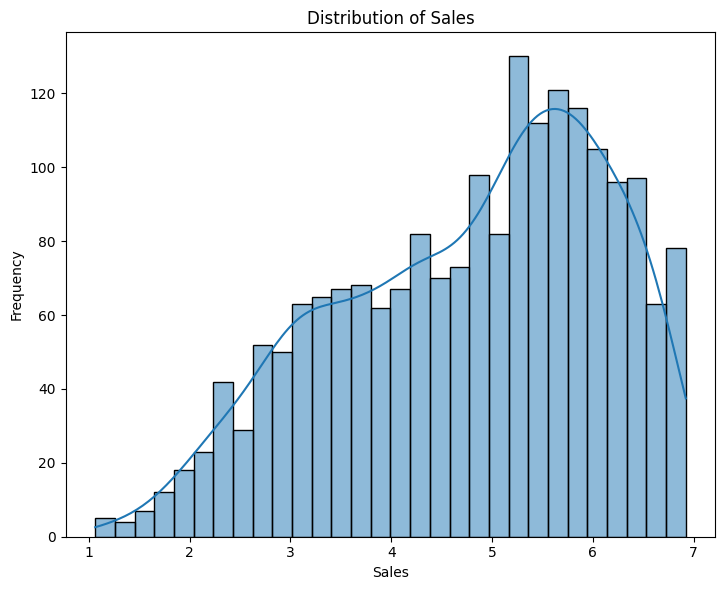

In [17]:
# Plot histplot to check distribution of sales
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data_cleaned['log_sales'], bins=30, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# # Box Plot
# plt.subplot(1, 2, 2)
# sns.boxplot(y=data_cleaned['sales'])
# plt.title('Box Plot of Sales')
# plt.ylabel('Sales')

plt.tight_layout()
plt.show()

In [18]:
# Save the cleaned dataset to a CSV file
data_cleaned.to_csv('cleaned_super_store_data.csv', index=False)

print("Cleaned dataset has been saved as 'cleaned_super_store_data.csv'.")

Cleaned dataset has been saved as 'cleaned_super_store_data.csv'.


#### Observations:
After applying the log transformation, we can see it is normally distributed now and ready to be fed to the model.

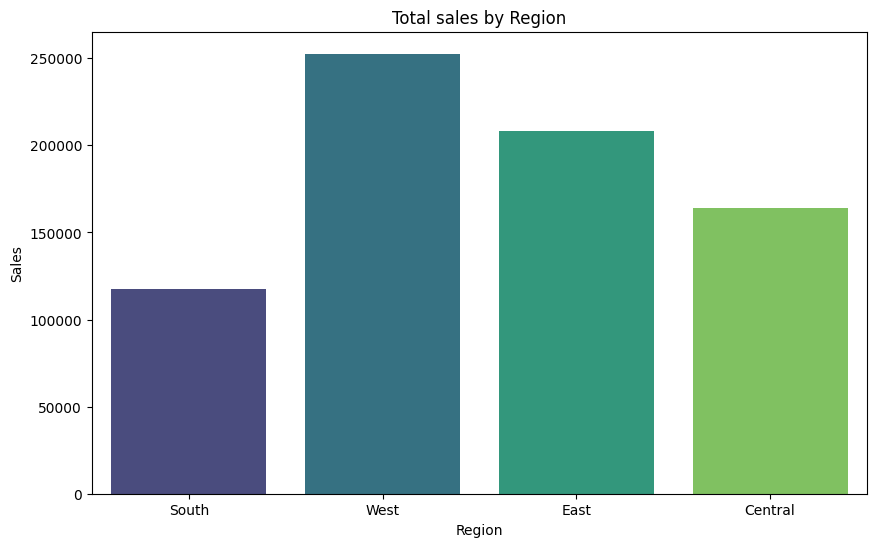

In [19]:
# Plot the total sales by region
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='sales', data=data, estimator=sum, ci=None, palette='viridis')
plt.title('Total sales by Region')
plt.xlabel('Region')
plt.ylabel('Sales')
plt.show()

#### Observations: 
Above figure shows that West region has more sales and South region has least sales. While East is at 2nd level and then comes the central region in terms of sales.

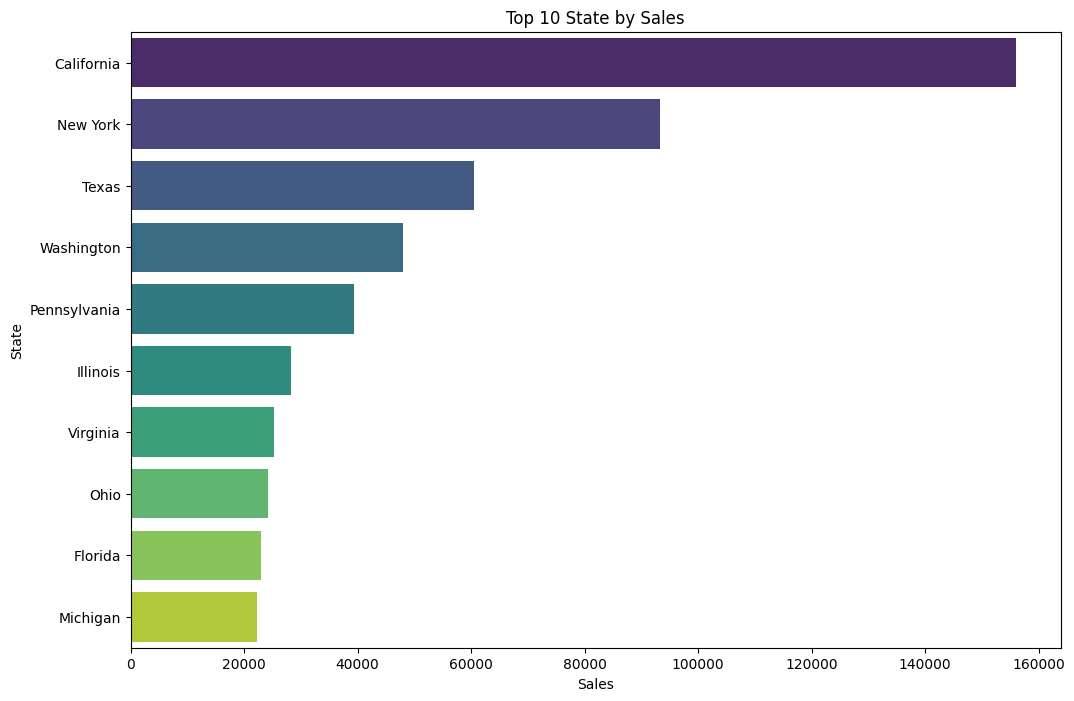

In [20]:
# Plot top 10 State  by sales
cities = data.groupby('state')['sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=cities.values, y=cities.index, palette='viridis')
plt.title('Top 10 State by Sales')
plt.xlabel('Sales')
plt.ylabel('State')
plt.show()

#### Observations:
Above plot suggests that California has done the highest sales out of all states in United States and Michigan the lowest. This completely depends on the population and various other factors that can be clearly seen from the above graph

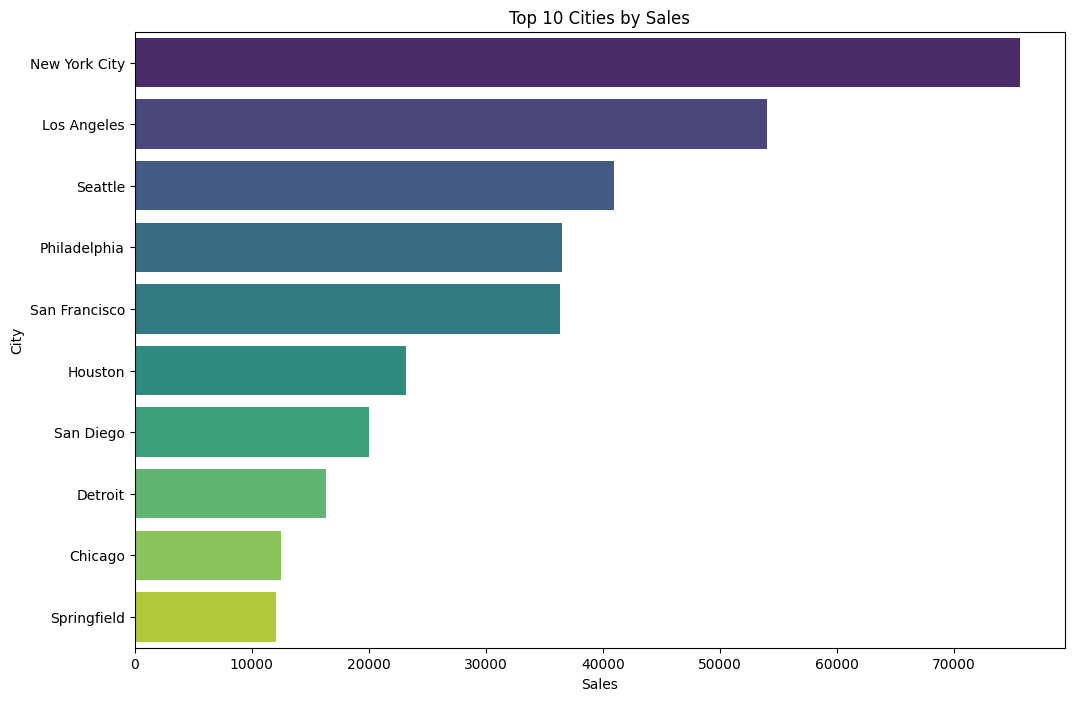

In [21]:
# Plot top 10 cities by sales
cities = data.groupby('city')['sales'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 8))
sns.barplot(x=cities.values, y=cities.index, palette='viridis')
plt.title('Top 10 Cities by Sales')
plt.xlabel('Sales')
plt.ylabel('City')
plt.show()

#### Observations:

New York city has sales of more than 70k which is the highest in all the cities of US and Springfield is the lowest in all the cities with around 10k of average sales.

In [22]:

# Calculate total sales per product
product_sales = data.groupby('sub-category', observed=True)['sales'].sum().sort_values(ascending=False)

# Prepare data for the top 10 products
top_10_products = product_sales.head(10).reset_index()
top_10_products.columns = ['sub-category', 'sales']

# Plot using Plotly
fig = px.bar(
    top_10_products,
    x='sub-category',
    y='sales',
    title='Top Furniture Products by Sales',
    labels={'sales': 'Sales (in USD)', 'sub-category': 'Product Sub-Category'},
    color='sales',
    color_continuous_scale='reds'
)

# Customize layout
fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    xaxis_tickangle=45,
    template='plotly',
    height=500,
    width=800,
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

# Show the plot
fig.show()


#### Observations:
We can see from above that top product in fruniture is Chairs above 300k and 2nd highest selling fruniture product is tables that is around 200k. Last one is furnishings with less than 100k sales amount.

In [23]:
# Calculate total sales per product per month
monthly_product_sales = data.groupby(['sub-category', 'year', 'month'])['sales'].sum().reset_index()

# Pivot the data to have products as columns and months as rows
monthly_product_sales_pivot = monthly_product_sales.pivot_table(index=['year', 'month'], columns='sub-category', values='sales', fill_value=0)

# Convert the MultiIndex to a single datetime index
monthly_product_sales_pivot.index = [pd.Timestamp(f'{year}-{month:02d}-01') for year, month in monthly_product_sales_pivot.index]

# Identify the top 5 products based on total sales
top_products = monthly_product_sales_pivot.sum(axis=0).sort_values(ascending=False).index[:5]

# Create a Plotly figure
fig = go.Figure()

# Add a line for each top product
for product in top_products:
    fig.add_trace(go.Scatter(
        x=monthly_product_sales_pivot.index,
        y=monthly_product_sales_pivot[product],
        mode='lines+markers',
        name=product
    ))

# Update the layout of the plot
fig.update_layout(
    title='Monthly Sales Trends for Top Furniture Category',
    xaxis_title='Date',
    yaxis_title='Sales',
    legend_title='Product',
    template='plotly',
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True),
    height=600,
    width=900
)

# Show the plot
fig.show()


#### Observations:
Above figure shows monthly sales trends for top furniture category.Highest sales is for chair in mostly December & January month.

In [24]:
# Calculate top 10 customers by total sales
top_customers = data.groupby('customer_name')['sales'].sum().sort_values(ascending=False).head(10).reset_index()
top_customers.columns = ['Customer Name', 'Total Sales']

# Create a Plotly bar chart
fig = px.bar(
    top_customers,
    x='Total Sales',
    y='Customer Name',
    orientation='h',  # Horizontal bar chart
    title='Top 10 Customers by Total Sales',
    text='Total Sales',  # Add labels directly to the bars
    labels={'Total Sales': 'Total Sales (USD)', 'Customer Name': 'Customer Name'},
    color='Total Sales',
    color_continuous_scale='viridis'
)

# Customize layout
fig.update_traces(
    texttemplate='$%{text:.2f}',  # Format labels as currency
    textposition='outside'  # Position labels outside the bars
)

fig.update_layout(
    title_font_size=16,
    xaxis_title_font_size=12,
    yaxis_title_font_size=12,
    height=600,
    width=900,
    xaxis=dict(showgrid=True, gridcolor='lightgray')
)

# Show the plot
fig.show()


#### Observations:
Above figure shows top 10 customers by total sales in USD. Bill Donatelli is premium customer with total purchase of  $4513. 

In [25]:
# Average Sales Analysis by Month, Week and Quarter
df_m_sa = data.groupby('month').agg({"sales" : "mean"}).reset_index()
df_m_sa['sales'] = round(df_m_sa['sales'],2)
df_m_sa['month_text'] = df_m_sa['month'].apply(lambda x: calendar.month_abbr[x])
df_m_sa['text'] = df_m_sa['month_text'] + ' - ' + df_m_sa['sales'].astype(str) 

df_w_sa = data.groupby('week').agg({"sales" : "mean"}).reset_index() 
df_q_sa = data.groupby('quarter').agg({"sales" : "mean"}).reset_index() 
# chart color
df_m_sa['color'] = '#496595'
df_m_sa['color'][:-1] = '#c6ccd8'
df_w_sa['color'] = '#c6ccd8'

# chart

fig = make_subplots(rows=2, cols=2, vertical_spacing=0.08,
                    row_heights=[0.7, 0.3], 
                    specs=[[{"type": "bar"}, {"type": "pie"}],
                           [{"colspan": 2}, None]],
                    column_widths=[0.7, 0.3],
                    subplot_titles=("Month wise Avg Sales Analysis", "Quarter wise Avg Sales Analysis", 
                                    "Week wise Avg Sales Analysis"))

fig.add_trace(go.Bar(x=df_m_sa['sales'], y=df_m_sa['month'], marker=dict(color= df_m_sa['color']),
                     text=df_m_sa['text'],textposition='auto',
                     name='Month', orientation='h'), 
                     row=1, col=1)
fig.add_trace(go.Pie(values=df_q_sa['sales'], labels=df_q_sa['quarter'], name='Quarter',
                     marker=dict(colors=['#334668','#496595','#6D83AA','#91A2BF','#C8D0DF']), hole=0.7,
                     hoverinfo='label+percent+value', textinfo='label+percent'), 
                     row=1, col=2)
fig.add_trace(go.Scatter(x=df_w_sa['week'], y=df_w_sa['sales'], mode='lines+markers', fill='tozeroy', fillcolor='#c6ccd8',
                     marker=dict(color= '#496595'), name='Week'), 
                     row=2, col=1)

# styling
fig.update_yaxes(visible=False, row=1, col=1)
fig.update_xaxes(visible=False, row=1, col=1)
fig.update_xaxes(tickmode = 'array', tickvals=df_w_sa.week, ticktext=[i for i in range(1,53)], 
                 row=2, col=1)
fig.update_yaxes(visible=False, row=2, col=1)
fig.update_layout(height=750, bargap=0.15,
                  margin=dict(b=0,r=20,l=20), 
                  title_text="Average Sales Analysis",
                  template="plotly_white",
                  title_font=dict(size=25, color='#8a8d93', family="Lato, sans-serif"),
                  font=dict(color='#8a8d93'),
                  hoverlabel=dict(bgcolor="#f2f2f2", font_size=13, font_family="Lato, sans-serif"),
                  showlegend=False)
fig.show()

#### Observations:
Above figure is created using plotly which shows clearly average sales quarterly, monthly and weekly. It shows that December is the highest selling month Febuary is the lowest selling month. If wee see quarterly then we can see almost all quarter contributes equally in percentage of sales. 

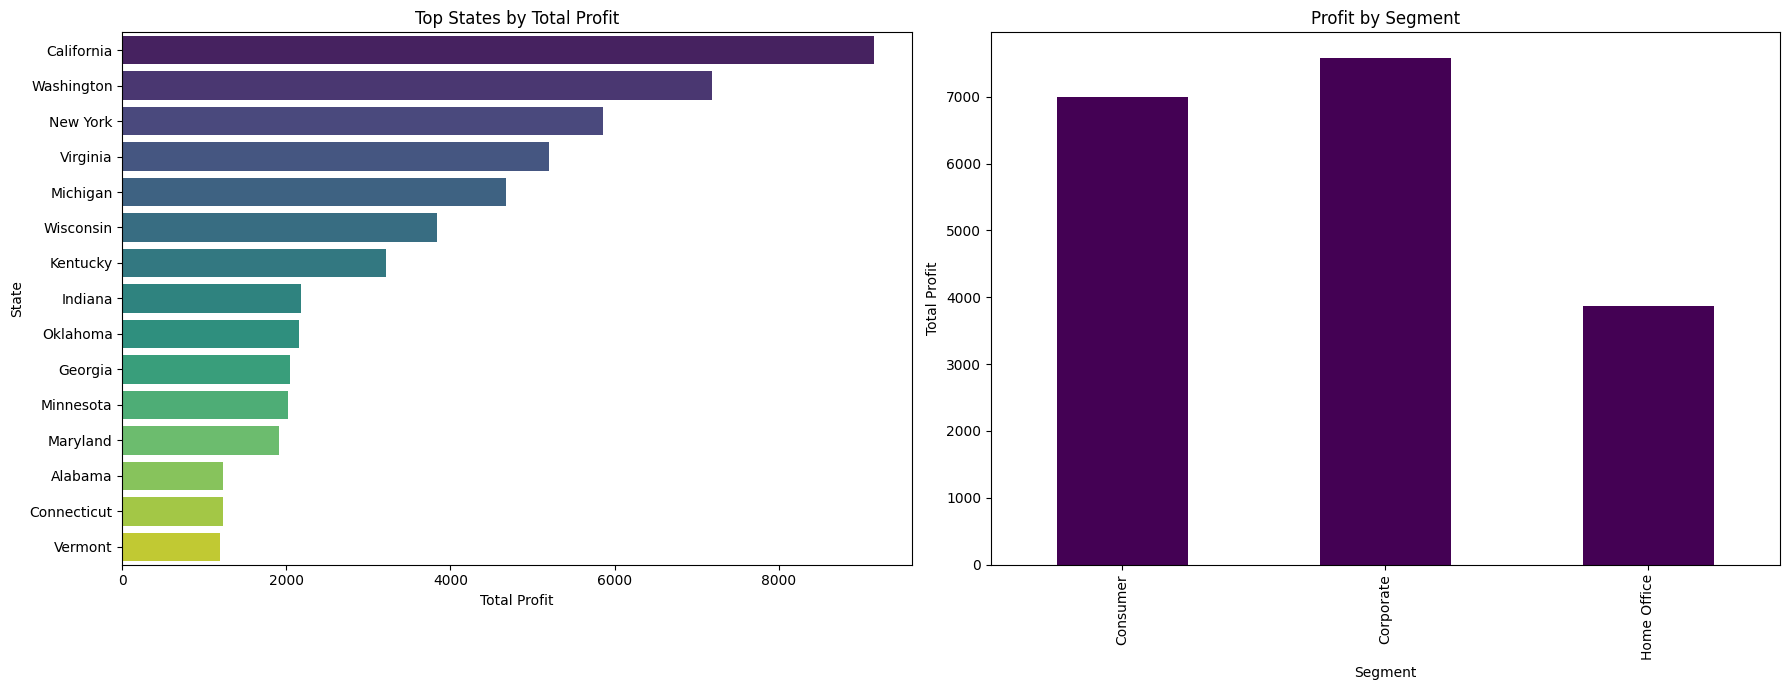

In [26]:
# Top States by Total Profit
top_states_profit = data.groupby('state')['profit'].sum().sort_values(ascending=False).head(15)

# Profit by Segment
segment_profit = data.groupby('segment')['profit'].sum()

# Set up subplots with one row and two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

# Plot 1: Top States by Profit
sns.barplot(x=top_states_profit.values, y=top_states_profit.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top States by Total Profit')
axes[0].set_xlabel('Total Profit')
axes[0].set_ylabel('State')

# Plot 2: Profit by Segment
segment_profit.plot(kind='bar', ax=axes[1], colormap='viridis')
axes[1].set_title('Profit by Segment')
axes[1].set_xlabel('Segment')
axes[1].set_ylabel('Total Profit')

plt.tight_layout()
plt.show()


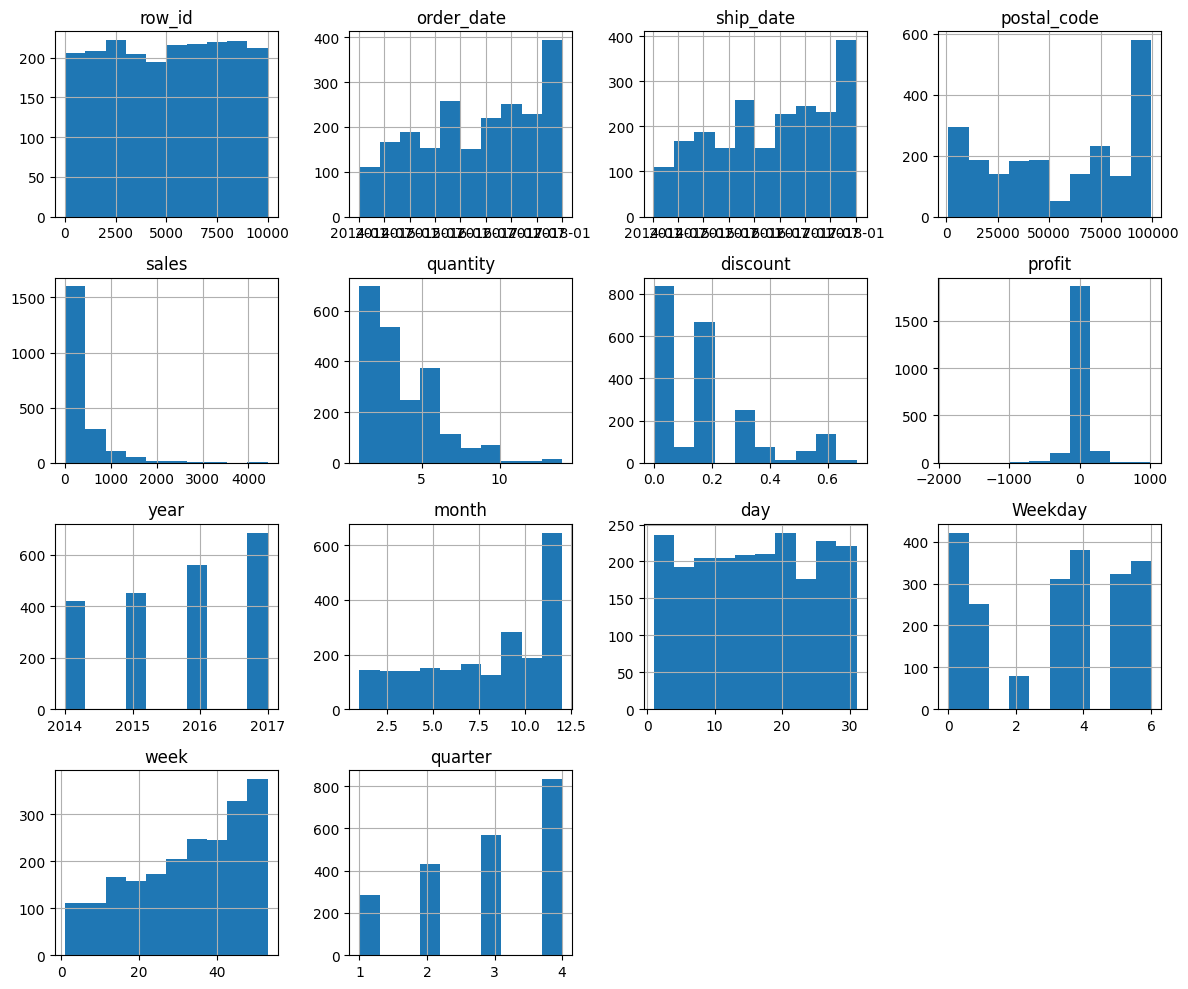

In [27]:
# Histogram of numerical columns
data.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

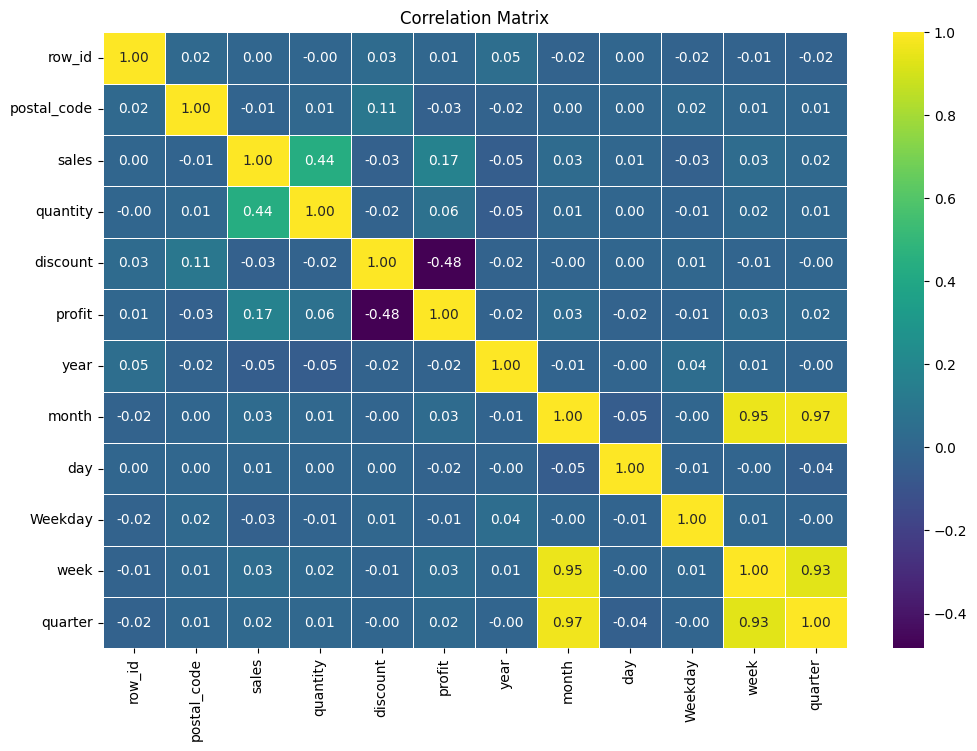

In [28]:
# Select only numeric columns
numeric_columns = data.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


#### Observations:

Correlation matrix helps to visualize the relationship between different variables in our furniture sales dataste. 
Variables  whicih we can in see in above figure slike row_id and postal_code shows very low or no correlation with key metrics (sales, profit), indicating they may not influence these outcomes directly.
Also, we can see that relationships between sales, profit, and quantity are positive but not particularly strong, suggesting other factors might influence these metrics.
In additon to that we can also see that discounts have a more noticeable negative impact on profit than on sales or quantity.

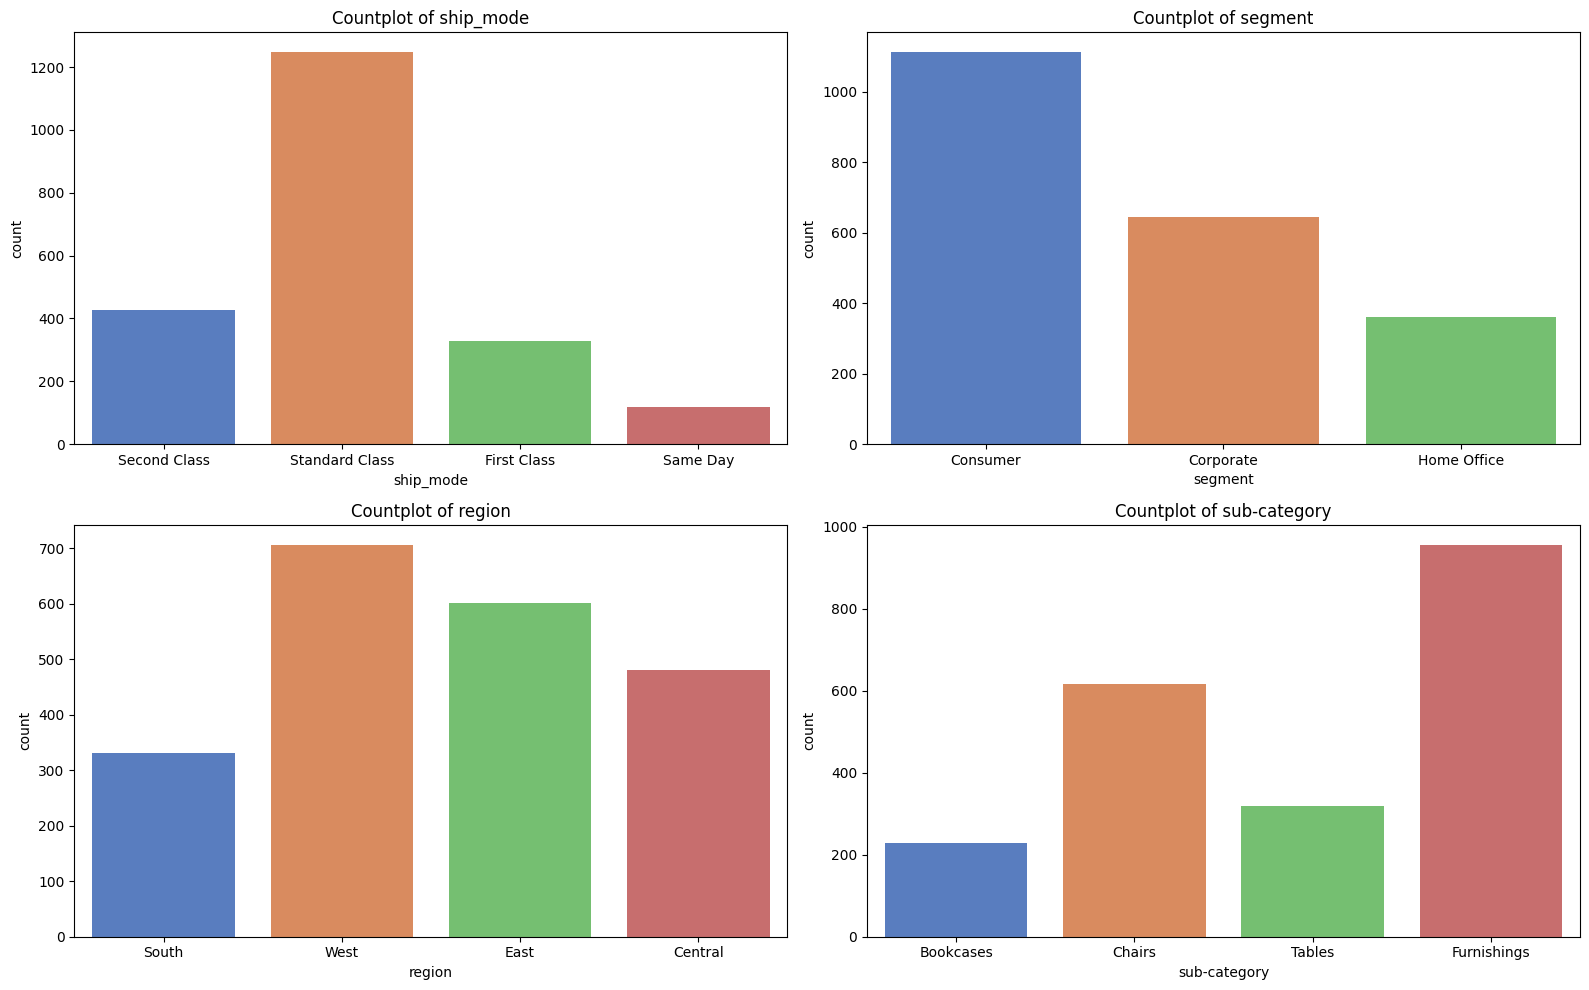

In [29]:
# Plotting the countplot of categorical columns
cate_columns = ['ship_mode', 'segment', 'region', 'sub-category']
plt.figure(figsize=(16, 10))
for i, col in enumerate(cate_columns, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, data=data, palette='muted')
    plt.title(f'Countplot of {col}')
plt.tight_layout()
plt.show()

## Time Series Analysis

In [30]:
# Aggregate sales data by 'Order Date'
aggregated_sales_data = data.groupby('order_date')['sales'].sum().reset_index()

# Resample the data to monthly frequency and sum the sales
monthly_sales_data = aggregated_sales_data.set_index('order_date').resample('M').sum().reset_index()
monthly_sales_data.columns = ['date', 'sales']

# Display the first few rows of the processed data
print(monthly_sales_data.head())


        date      sales
0 2014-01-31   6242.525
1 2014-02-28   1839.658
2 2014-03-31  14573.956
3 2014-04-30   7944.837
4 2014-05-31   6912.787


#### Observations:
We can see that dataset needs to be prepared for time series so for that we have aggregated the data to monthly frequency and summed up the sales variable since our main aim is to forecast monthly furniture sales for store. Data and sales columns we can see which will be used at later stage for Modelling purposes.

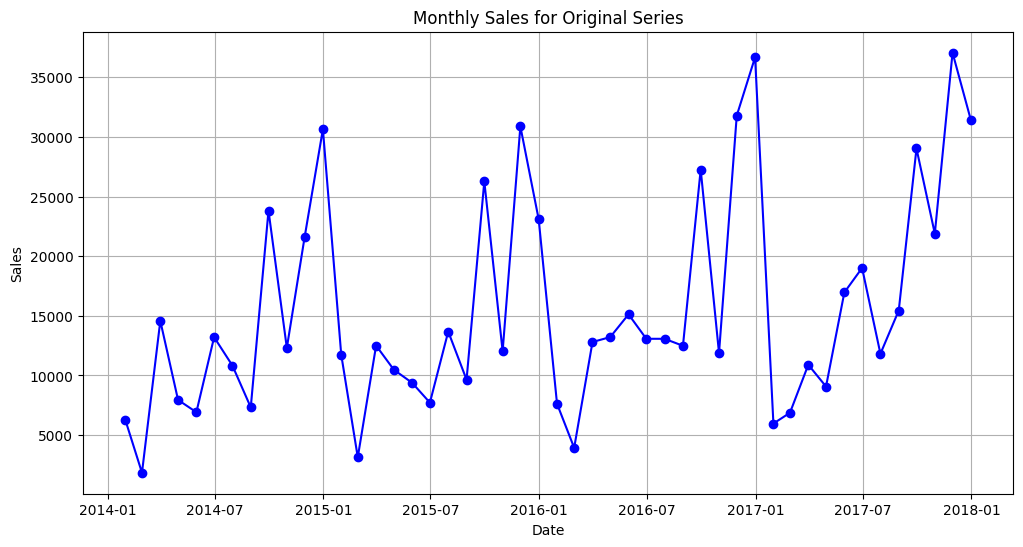

In [31]:
# Plot the monthly sales data
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales_data['date'], monthly_sales_data['sales'], marker='o', linestyle='-', color='blue')
plt.title('Monthly Sales for Original Series')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.show()

#### Observations:

We can see from above figure monthly sales of furniture which starts from 2014-2018 and also we can see spikes in January month and less sale in Febuary month.

## Stationarity Check Using ADF Test

In [32]:
data_diff_1 = monthly_sales_data.diff().dropna()
data_diff_2 = monthly_sales_data.diff().dropna()

print('Test stationarity for original series')
print('-------------------------------------')
# Perform the Augmented Dickey-Fuller test on the overall sales data
result = adfuller(monthly_sales_data['sales'])

# Display the test results
stationarity_results = {
    "Test Statistic": result[0],
    "P-value": result[1],
    "Critical Values": result[4],
    "Stationarity": "Stationary" if result[1] <= 0.05 else "Not Stationary"
}

print("Stationarity Test Results:")
print(stationarity_results)

print('\nTest stationarity for differenced series (order=1)')
print('--------------------------------------------------')


result = adfuller(data_diff_1['sales'])

# Display the test results
stationarity_results = {
    "Test Statistic": result[0],
    "P-value": result[1],
    "Critical Values": result[4],
    "Stationarity": "Stationary" if result[1] <= 0.05 else "Not Stationary"
}

print("Stationarity Test Results:")
print(stationarity_results)



Test stationarity for original series
-------------------------------------
Stationarity Test Results:
{'Test Statistic': -4.699026242828903, 'P-value': 8.450793985809654e-05, 'Critical Values': {'1%': -3.5778480370438146, '5%': -2.925338105429433, '10%': -2.6007735310095064}, 'Stationarity': 'Stationary'}

Test stationarity for differenced series (order=1)
--------------------------------------------------
Stationarity Test Results:
{'Test Statistic': -11.474589263481011, 'P-value': 5.167970563426405e-21, 'Critical Values': {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}, 'Stationarity': 'Stationary'}


##### Observations: 

The ADF test is used to check if a time series is stationary i.e its mean, variance and autocovariance don't change over time. As stationary is very crucial for time series forcasting models liek ARIMA as non-stationary data can lead to unreliable predictions.

Original Series:

Test Statistic: -4.699 (less than all critical values, e.g., -3.577 for 1%).
P-value: 0.000084 (< 0.05).
Conclusion: The null hypothesis (series is non-stationary) is rejected. The series is stationary without the need for differencing.
Differenced Series (Order = 1):

Test Statistic: -11.475 (much lower than all critical values).
P-value: ~0 (< 0.05).
Conclusion: The differenced series is highly stationary, further confirming that any residual trends in the original series have been eliminated after differencing.

#### ACF Plot for original and difference data

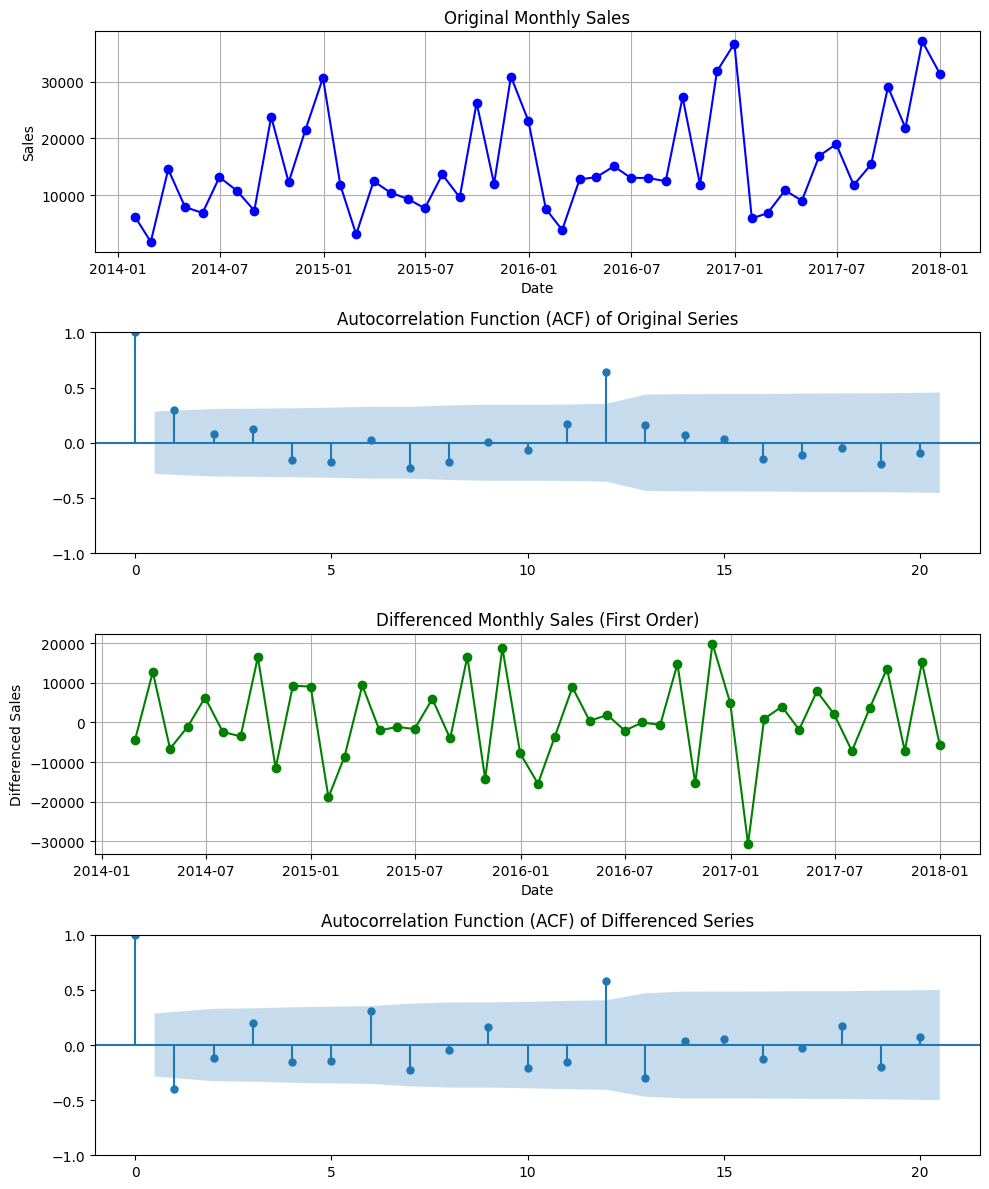

In [33]:
# Create the differenced_sales column
monthly_sales_data['differenced_sales'] = monthly_sales_data['sales'].diff()

# Plot original series, its ACF, differenced series, and ACF of the differenced series
plt.figure(figsize=(10, 12))

# Original series
plt.subplot(4, 1, 1)
plt.plot(monthly_sales_data['date'], monthly_sales_data['sales'], marker='o', linestyle='-', color='blue')
plt.title('Original Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()

# ACF of original series
plt.subplot(4, 1, 2)
plot_acf(monthly_sales_data['sales'], ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function (ACF) of Original Series')

# Differenced series
plt.subplot(4, 1, 3)
plt.plot(monthly_sales_data['date'][1:], monthly_sales_data['differenced_sales'][1:], marker='o', linestyle='-', color='green')
plt.title('Differenced Monthly Sales (First Order)')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.grid()

# ACF of differenced series
plt.subplot(4, 1, 4)
plot_acf(monthly_sales_data['differenced_sales'].dropna(), ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function (ACF) of Differenced Series')

plt.tight_layout()
plt.show()


#### Observations:
##### Autocorrelation Function (ACF) plot in above figure helps us to understand how a time series is related to its past values or lags. It measures the correlation between the series and its lagged versions, and helps to identify patterns such as seasonality, trends, and whether differencing is required for stationarity. ACF is very useful  for selecting appropriate time series models like ARIMA.

##### Original Monthly Sales (Top Plot):

##### We can see that original series in the above figure shows clear fluctuations and trends, suggesting non-stationarity. Alo, this aligns with the spikes in the ACF plot of the original series (second plot), where correlations persist across many lags. And hence indicates the presence of trends and seasonality.

##### Differenced Monthly Sales (Middle Plot):

##### We can see that after first-order differencing, the series appears more stable, with fluctuations centered around zero. This reflects in the ACF plot of the differenced series (bottom plot), where most correlations quickly drop off after lag 1. And indicates that the differenced series has largely removed trends and achieved stationarity.

##### We can see that ACF of the original series shows significant correlations across multiple lags, and confirms non-stationarity. The ACF of the differenced series shows minimal correlation beyond lag 1, confirming that differencing successfully removed trends, making the data suitable for ARIMA modeling.

#### PACF Plot for original and differenced series

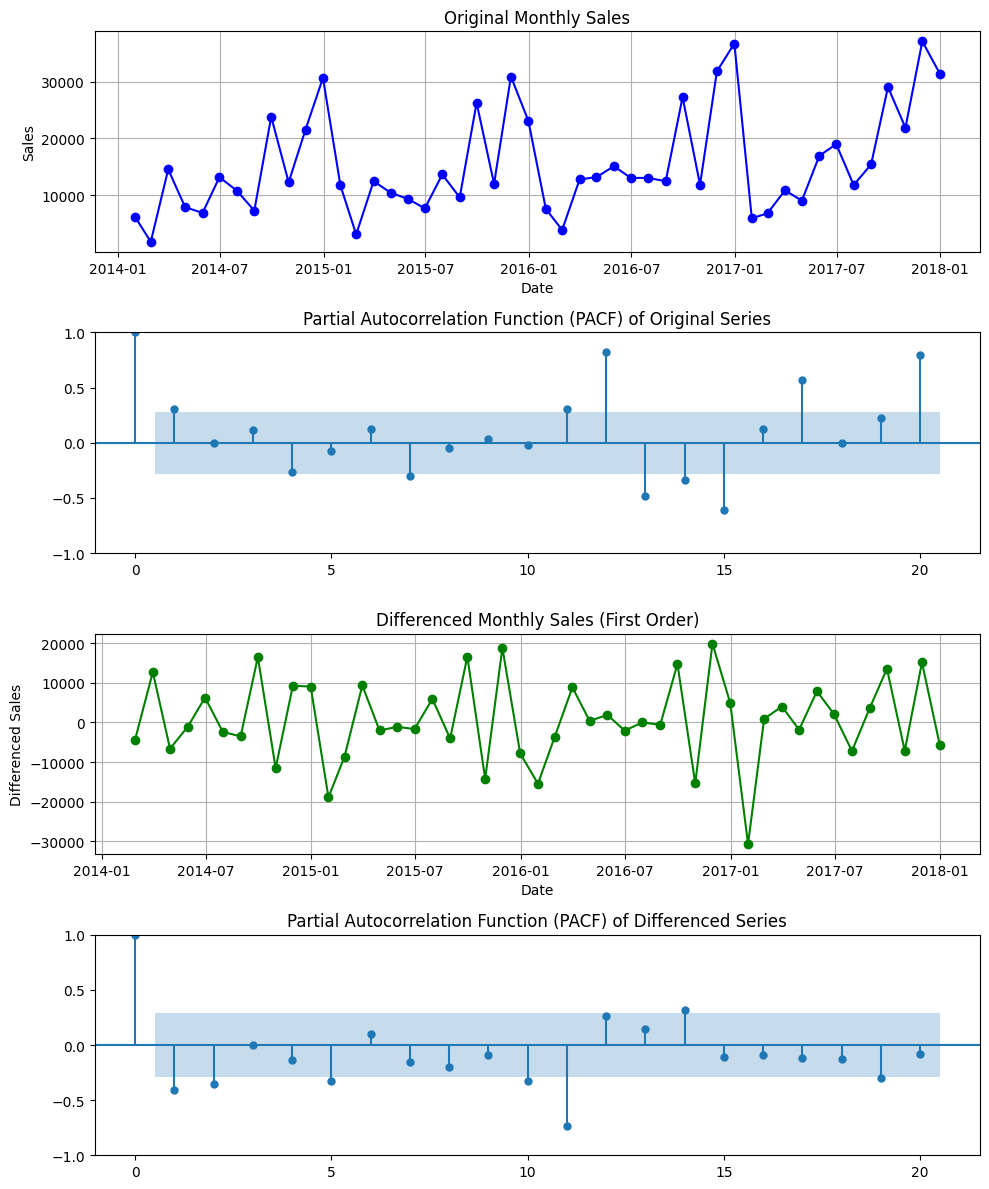

In [34]:
# Plot original series, its PACF, differenced series, and PACF of the differenced series
plt.figure(figsize=(10, 12))

# Original series
plt.subplot(4, 1, 1)
plt.plot(monthly_sales_data['date'], monthly_sales_data['sales'], marker='o', linestyle='-', color='blue')
plt.title('Original Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()

# PACF of original series
plt.subplot(4, 1, 2)
plot_pacf(monthly_sales_data['sales'], ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function (PACF) of Original Series')

# Differenced series
plt.subplot(4, 1, 3)
plt.plot(monthly_sales_data['date'][1:], monthly_sales_data['differenced_sales'][1:], marker='o', linestyle='-', color='green')
plt.title('Differenced Monthly Sales (First Order)')
plt.xlabel('Date')
plt.ylabel('Differenced Sales')
plt.grid()

# PACF of differenced series
plt.subplot(4, 1, 4)
plot_pacf(monthly_sales_data['differenced_sales'].dropna(), ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function (PACF) of Differenced Series')

plt.tight_layout()
plt.show()


##### Observations:
Partial Autocorrelation Function (PACF) helps to measures the correlation between a time series and its lags while controlling for the influence of intermediate lags. PACF helps identify the order of the AR (Auto-Regressive) term in time series models, such as ARIMA, by determining how many past values directly influence the current value.

We can see that PACF of the original series suggests that there is  presence of long-term dependencies which confirms non-stationarity.
Also, PACF of the differenced series highlights that only the first lag is significantly correlated, which makes it suitable for modeling with a low-order AR term in ARIMA or SARIMA models.

#### Decomposition of original and differenced series

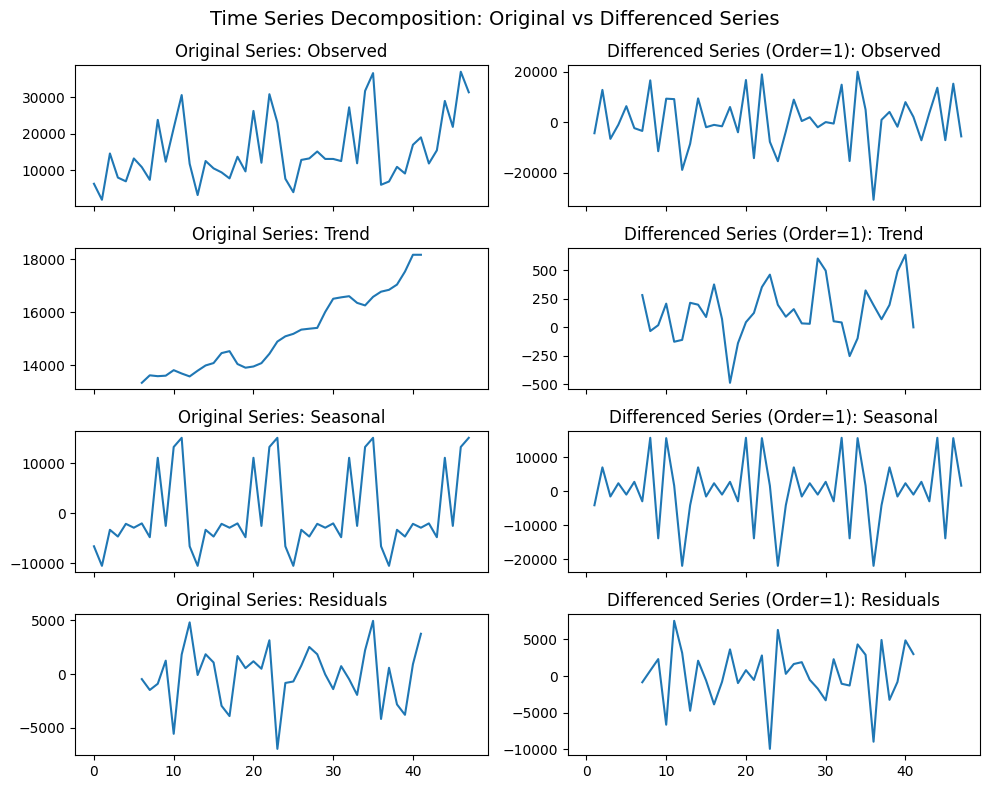

In [35]:
# Decompose the original series and the first-order differenced series
res_decompose = seasonal_decompose(monthly_sales_data['sales'], model='additive', period=12)
res_descompose_diff_1 = seasonal_decompose(monthly_sales_data['sales'].diff().dropna(), model='additive', period=12)

# Plot the decomposition results
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 8), sharex=True)

# Original series decomposition
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original Series: Observed', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Original Series: Trend', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Original Series: Seasonal', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Original Series: Residuals', fontsize=12)

# Differenced series decomposition
res_descompose_diff_1.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Differenced Series (Order=1): Observed', fontsize=12)
res_descompose_diff_1.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Differenced Series (Order=1): Trend', fontsize=12)
res_descompose_diff_1.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Differenced Series (Order=1): Seasonal', fontsize=12)
res_descompose_diff_1.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Differenced Series (Order=1): Residuals', fontsize=12)

fig.suptitle('Time Series Decomposition: Original vs Differenced Series', fontsize=14)
fig.tight_layout()
plt.show()


#### Observations:

Above figure shows graphs for observed, trends, seasonality and residuals.
We can clearly see from the graph the original series is non-stationary due to the trend and seasonality.
And differenced series achieves stationarity by removing the trend while retaining seasonal and random components.
These transformations makes the data suitable for modeling with techniques like ARIMA or SARIMA.

## Model Implementation

### ARIMA Model (Auto-ARIMA AND SARIMAX)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=715.201, Time=0.32 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=708.796, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=709.325, Time=0.04 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=709.756, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=711.529, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=707.976, Time=0.03 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=707.744, Time=0.08 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=709.738, Time=0.16 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=709.855, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=709.579, Time=0.10 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=709.985, Time=0.11 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=711.977, Time=0.17 sec
 ARIMA(0,0,0)(2,1,0)[12]             : AIC=708.710, Time=0.10 sec

Best model:  ARIMA(0,0,0)(2,1,0)[12] intercept
Total fit time: 1.235 seconds
Optimal ARIMA Order: 

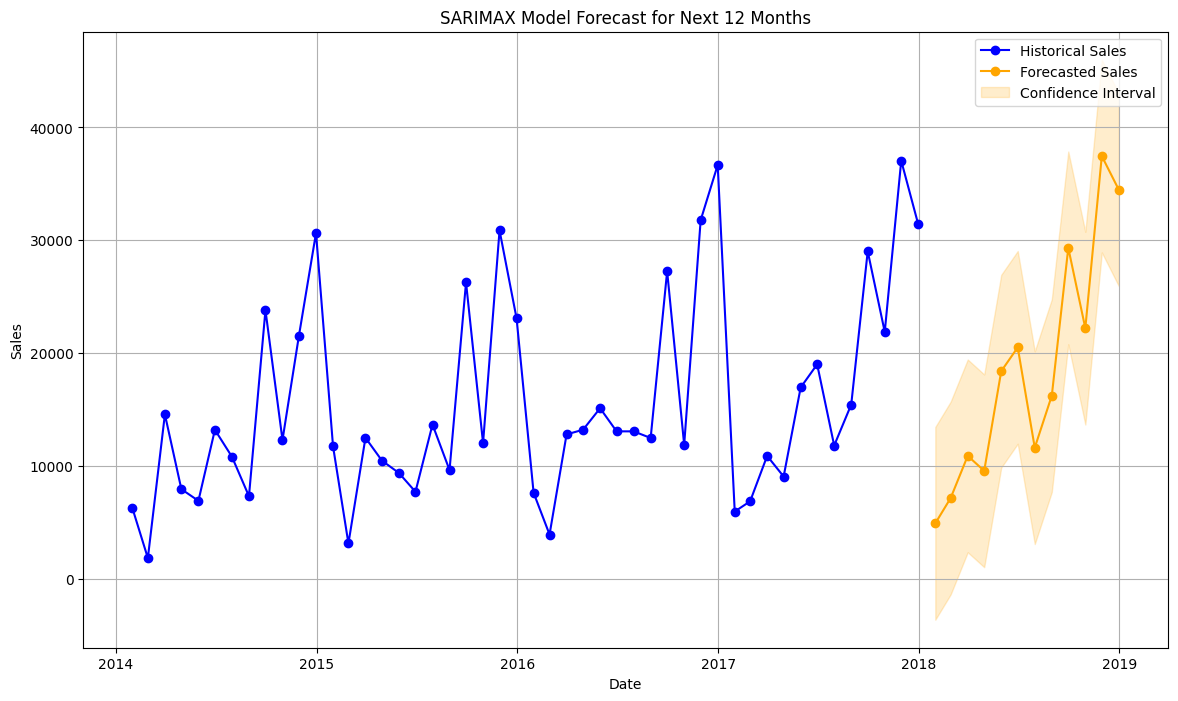

In [36]:
# Fit an ARIMA model using auto_arima to determine optimal parameters
auto_arima_model = auto_arima(
    monthly_sales_data['sales'],
    seasonal=True,
    m=12,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

# Display the suggested ARIMA order and seasonal order
print(f"Optimal ARIMA Order: {auto_arima_model.order}")
print(f"Optimal Seasonal Order: {auto_arima_model.seasonal_order}")

# Fit a SARIMAX model using the optimal parameters
sarimax_model = SARIMAX(
    monthly_sales_data['sales'],
    order=auto_arima_model.order,
    seasonal_order=auto_arima_model.seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

fitted_model = sarimax_model.fit(disp=False)

# Forecast the next 12 months
forecast = fitted_model.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Evaluate model performance on historical data
historical_forecast = fitted_model.fittedvalues
mae = mean_absolute_error(monthly_sales_data['sales'], historical_forecast)
mse = mean_squared_error(monthly_sales_data['sales'], historical_forecast)
mape = (np.abs((monthly_sales_data['sales'] - historical_forecast) / monthly_sales_data['sales']).mean()) * 100
r2 = r2_score(monthly_sales_data['sales'], historical_forecast)

# Display evaluation metrics
evaluation_metrics = {
    "Mean Absolute Error (MAE)": mae,
    "Mean Squared Error (MSE)": mse,
    "Mean Absolute Percentage Error (MAPE)": mape,
    "R-squared (R2)": r2
}
print("Evaluation Metrics:")
print(evaluation_metrics)

# Visualize the forecast
forecast_dates = pd.date_range(
    start=monthly_sales_data['date'].iloc[-1] + pd.offsets.MonthBegin(1), 
    periods=12, 
    freq='M'
)

plt.figure(figsize=(14, 8))
plt.plot(monthly_sales_data['date'], monthly_sales_data['sales'], label='Historical Sales', marker='o', color='blue')
plt.plot(forecast_dates, forecast_mean, label='Forecasted Sales', marker='o', color='orange')
plt.fill_between(forecast_dates, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='orange', alpha=0.2, label='Confidence Interval')
plt.title('SARIMAX Model Forecast for Next 12 Months')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()


#### Observations: 

We can see from the graph that historical sales (blue) and SARIMAX's 12-month forecast (orange) with confidence intervals (shaded). The model uses ARIMA(0,0,0)(2,1,0)[12], capturing seasonality but not trends well.

Key Metrics:
'MAE: 5872 (average deviation from actual sales).
MAPE: 43.73% (forecast error is high).
R²: 0.11 (explains only 10.9% of variance).
##### Conclusion: The model captures seasonality well but still has limited accuracy, with significant room for improvement.

### Prophet Model

22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing


Prophet Evaluation Metrics:
{'Mean Absolute Error (MAE)': 1877.451706817751, 'Mean Squared Error (MSE)': 5513545.572434576, 'Mean Absolute Percentage Error (MAPE)': 15.859204139869231, 'R-squared (R2)': 0.9320594797890768}


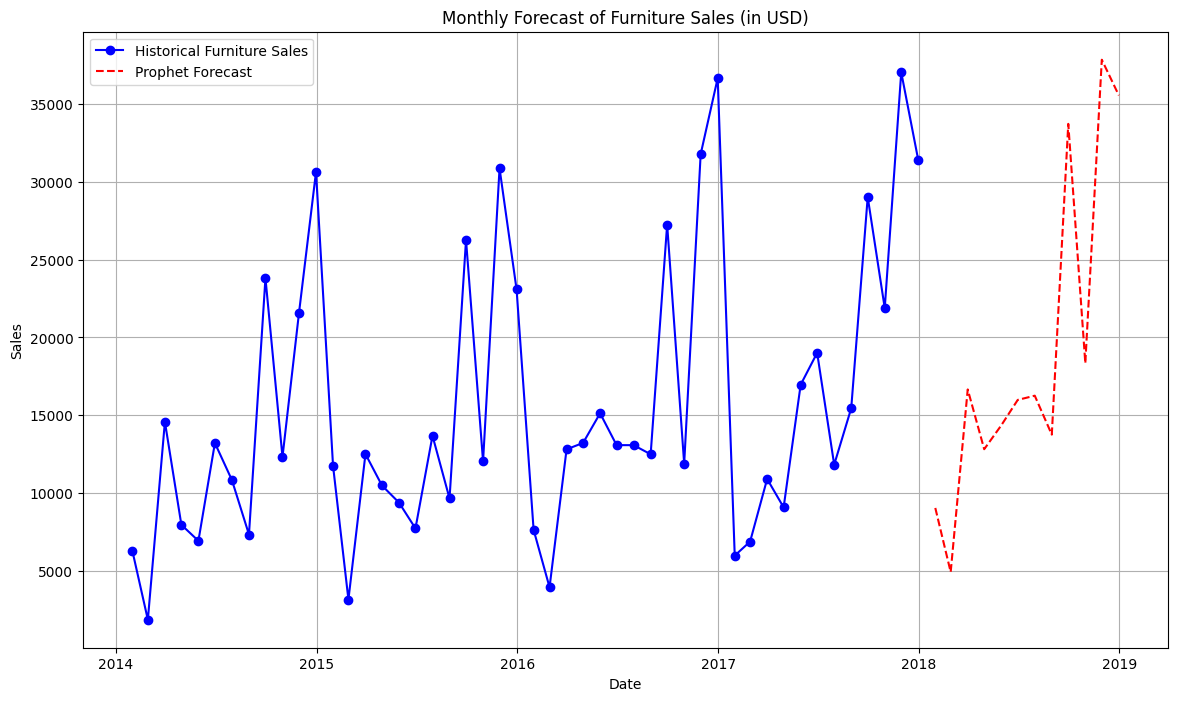

In [37]:
# Prepare the data for Prophet
prophet_data = monthly_sales_data.rename(columns={'date': 'ds', 'sales': 'y'})

# Initialize and fit the Prophet model
prophet_model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
prophet_model.fit(prophet_data)

# Create future dates for 12-month forecast
future_dates = prophet_model.make_future_dataframe(periods=12, freq='M')

# Generate the forecast
forecast_prophet = prophet_model.predict(future_dates)

# Only show forecasted sales after the last historical date
forecast_after_train = forecast_prophet[forecast_prophet['ds'] > prophet_data['ds'].max()]

# Evaluate Prophet model performance on historical data
y_true = prophet_data['y']
y_pred_prophet = forecast_prophet.loc[forecast_prophet['ds'].isin(prophet_data['ds']), 'yhat']
mae_prophet = mean_absolute_error(y_true, y_pred_prophet)
mse_prophet = mean_squared_error(y_true, y_pred_prophet)
mape_prophet = (np.abs((y_true - y_pred_prophet) / y_true).mean()) * 100
r2_prophet = r2_score(y_true, y_pred_prophet)

# Display evaluation metrics for Prophet
evaluation_metrics_prophet = {
    "Mean Absolute Error (MAE)": mae_prophet,
    "Mean Squared Error (MSE)": mse_prophet,
    "Mean Absolute Percentage Error (MAPE)": mape_prophet,
    "R-squared (R2)": r2_prophet
}
print("Prophet Evaluation Metrics:")
print(evaluation_metrics_prophet)

# Visualize the comparison of ARIMA and Prophet forecasts
plt.figure(figsize=(14, 8))
plt.plot(prophet_data['ds'], prophet_data['y'], label='Historical Furniture Sales', marker='o', color='blue')

# Prophet forecast
plt.plot(forecast_after_train['ds'], forecast_after_train['yhat'], label='Prophet Forecast', linestyle='--', color='red')

plt.title('Monthly Forecast of Furniture Sales (in USD)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()


#### Observations:
We can see from the above graph that the historical furniture sales (blue line) alongside the Prophet model's 12-month forecast (red dashed line).

Also, the blue line represents actual sales trends over time, with clear seasonality and fluctuations.
The red dashed line indicates the predicted sales for the next 12 months using the Prophet model, extending beyond the historical data and capturing the seasonal patterns.
Evaluation Metrics for Prophet:
Mean Absolute Error (MAE): 1877.45
On average, the forecasted sales deviate by 1877 units from actual sales.
Mean Squared Error (MSE): 5,513,545
The squared error is relatively low compared to ARIMA, indicating better fit.
Mean Absolute Percentage Error (MAPE): 15.86%
The forecast error is significantly lower compared to ARIMA, suggesting better prediction accuracy.
R-squared (R²): 0.93

The model explains 93% of the variation in sales, indicating a very good fit.

Conclusion:
The Prophet model performs much better than ARIMA, with higher accuracy (low MAPE and high R²). It effectively captures the seasonality and trends, making it a strong choice for time series forecasting in this scenario.

#### Benchmarking Result

In [38]:
# Consolidate evaluation metrics for ARIMA and Prophet models
benchmarking_results = {
    "Model": ["ARIMA", "Prophet"],
    
    "R-squared": [
        evaluation_metrics["R-squared (R2)"],
        evaluation_metrics_prophet["R-squared (R2)"]
    ],
    "MAE": [
        evaluation_metrics["Mean Absolute Error (MAE)"],
        evaluation_metrics_prophet["Mean Absolute Error (MAE)"]
    ],
    "MSE": [
        evaluation_metrics["Mean Squared Error (MSE)"],
        evaluation_metrics_prophet["Mean Squared Error (MSE)"]
    ],
    "MAPE": [
        evaluation_metrics["Mean Absolute Percentage Error (MAPE)"],
        evaluation_metrics_prophet["Mean Absolute Percentage Error (MAPE)"]
    ]

}

# Create a DataFrame for benchmarking results
benchmarking_df = pd.DataFrame(benchmarking_results)

# Print the benchmarking table
print("Model Benchmarking Results:")
print(benchmarking_df)


Model Benchmarking Results:
     Model  R-squared          MAE           MSE       MAPE
0    ARIMA   0.109030  5872.399678  7.230446e+07  43.735713
1  Prophet   0.932059  1877.451707  5.513546e+06  15.859204


#### Observations: 

From above we can conclude that Prophet model has performed well than ARIMA model as in above benchmarking results Prophet's R-squared of 0.932 suggests that it explains approx. 93.2% of the variance in the data whereas ARIMA's 0.109 indicates it explains about 10.9%. We evaluated model's performance using various metrics such as R², MAPE, MSE, MAE and model benchmarking results can be seen above. Prophet model outperformed SARIMAX with R² value of 0.93 and MAPE value of 15.85% which indicates better accuracy and fit to this data. MSE and MAE also showed reasonable accuracy.

#### Save Prophet Model

In [39]:
# Save the Prophet model to a Pickle file
with open("prophet_model.pkl", "wb") as f:
    pickle.dump(prophet_model, f)

print("Prophet model has been saved as 'prophet_model.pkl'.")


Prophet model has been saved as 'prophet_model.pkl'.


#### Observations:
Saving the above model in pickel is very useful as pickel saves in serialized format which loads very quickly. So, while using this model in production, we don't have to train the model again for prediction as it is computationally very expensive. 

#### Load Prophet Model & Forecast Next 12 months sales

In [40]:
# Load the Prophet model from the Pickle file
with open("prophet_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)
    
# Generate future dates for forecasting
future_dates = loaded_model.make_future_dataframe(periods=12, freq='M')

# Generate forecasts
future_forecast = loaded_model.predict(future_dates)

# Display forecasted values
print("Forecasted Sales for Next 12 Months:")
print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(12))



Forecasted Sales for Next 12 Months:
           ds          yhat    yhat_lower    yhat_upper
48 2018-01-31   9030.052766   6177.480640  12150.702102
49 2018-02-28   4905.662156   1811.100912   7860.652587
50 2018-03-31  16654.086465  13555.742046  19646.368326
51 2018-04-30  12808.196479   9735.818949  15949.921574
52 2018-05-31  14340.949101  11196.227183  17254.574722
53 2018-06-30  15979.423326  12875.055807  18746.388969
54 2018-07-31  16251.576595  13378.219081  19178.700745
55 2018-08-31  13745.448306  10814.344504  16586.641268
56 2018-09-30  33737.134053  30659.650050  36823.867669
57 2018-10-31  18344.328759  15366.051654  21272.569961
58 2018-11-30  37863.286201  34569.833690  40759.366652
59 2018-12-31  35570.239933  32653.367520  38273.128194


#### Observations:
In above section, we can see the forecast of next 12 months sales of furniture store. For this prophet model has been loaded and then prediction is done on that loaded model. ds shows the date column and yhat means predicted sales coulumn. Here yhat_lower and yhat_upper shows the lower bound and upper bound of the prediction. This is the confidence interval which suggests that prediction will be within this limit only.

## Conclusion:
We can conclude by seeing the results from prophet model. We have completed forecasting furniture sales using the Prophet model. We have performed detailed steps like data preprocessing, time series decomposition, and evaluation of forecast accuracy using metrics such as MAE, MSE, MAPE, and R². The model effectively captures seasonality and trends in the sales data, achieving high accuracy with an R² of ~0.93 and low MAPE. This approach is well-suited for predicting future sales and supports business decision-making by providing reliable insights into future demand.